
# TweetEval Sentiment — TF‑IDF vs GPT‑4 (Colab)

**Objective:** Combine a strong **TF‑IDF baseline** with a **GPT‑4 zero‑shot** classifier on the TweetEval **sentiment** task, and show—through **EDA, plots, and evaluation matrices**—how GPT‑4 beats (or differs from) TF‑IDF.

> **EDA rubric note:** The EDA below follows the uploaded rubric: data quality, univariate distributions, feature engineering rationale, and compact visual evidence to support modeling choices.


In [1]:

#@title ⬇️ Install & imports (Colab-safe)
!pip -q install datasets scikit-learn matplotlib seaborn nltk evaluate wordcloud tiktoken openai==1.* tqdm emoji --progress-bar off

import os, re, json, time, random, pathlib, textwrap
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sklearn.metrics import (classification_report, confusion_matrix, f1_score, accuracy_score)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from wordcloud import WordCloud
from tqdm.auto import tqdm
import emoji

plt.rcParams["figure.figsize"] = (8, 5)
sns.set_context("talk"); sns.set_style("whitegrid")

OUT_DIR = pathlib.Path("outputs"); OUT_DIR.mkdir(parents=True, exist_ok=True)
SEED = 42
random.seed(SEED); np.random.seed(SEED)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



## 1) Load dataset
We use **TweetEval / sentiment** via 🤗 `datasets`. Labels: `0=negative`, `1=neutral`, `2=positive`.


In [2]:

subset = "sentiment"
ds = load_dataset("tweet_eval", subset)

train_df = pd.DataFrame(ds["train"])
val_df   = pd.DataFrame(ds["validation"])
test_df  = pd.DataFrame(ds["test"])

label_names = ["negative", "neutral", "positive"]
def decode_label(y: int) -> str: return label_names[int(y)]
for df in (train_df, val_df, test_df): df["label_name"] = df["label"].apply(decode_label)

print({k: len(v) for k,v in {"train":train_df, "validation":val_df, "test":test_df}.items()})
train_df.head(3)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{'train': 45615, 'validation': 2000, 'test': 12284}


,text,label,label_name
0,"""QT @user In the original draft of the 7th boo...",2,positive
1,"""Ben Smith / Smith (concussion) remains out of...",1,neutral
2,Sorry bout the stream last night I crashed out...,1,neutral



## 2) Preprocessing (minimal, sentiment‑preserving)
**Why minimal:** Over‑cleaning deletes sentiment cues (elongations, punctuation, hashtags). We:
- Replace URLs with `<URL>` and mentions with `@user` (reduces sparsity).
- Keep hashtags (as tokens) and general casing handled by vectorizer.

We also compute lightweight numeric features needed for EDA (token length, emoji count, URL/hashtag/mention flags, punctuation ratio).


In [3]:

url_pat = re.compile(r"https?://\S+|www\.\S+")
mention_pat = re.compile(r"@\w+")
multi_ws_pat = re.compile(r"\s+")

def clean_text(text: str) -> str:
    text = url_pat.sub(" <URL> ", text)
    text = mention_pat.sub(" @user ", text)
    text = text.replace("#", " #")
    text = multi_ws_pat.sub(" ", text).strip()
    return text

def count_emojis(s: str) -> int:
    return sum(ch in emoji.EMOJI_DATA for ch in s)

def punct_ratio(s: str) -> float:
    if not s: return 0.0
    punct = sum(ch in ".,!?;:()[]{}\"'…–—" for ch in s)
    return punct / max(1, len(s))

for df in (train_df, val_df, test_df):
    df["text_clean"] = df["text"].astype(str).apply(clean_text)
    df["n_tokens"] = df["text_clean"].str.split().apply(len)
    df["has_url"] = df["text"].str.contains(url_pat).astype(int)
    df["has_hash"] = df["text"].str.contains("#").astype(int)
    df["has_mention"] = df["text"].str.contains(mention_pat).astype(int)
    df["n_emojis"] = df["text"].apply(count_emojis)
    df["punct_ratio"] = df["text"].apply(punct_ratio)



## 3) EDA (focused + explanatory)

**What we need to know (per rubric):**
- **Class balance:** Ensure enough signal in each class.
- **Text length:** Distribution and outliers (helps pick `ngram_range`, `min_df`).
- **Lexical cues:** Which n‑grams dominate each class (storytelling + model features).
- **Simple numeric relationships:** Are URL/hashtag/mentions correlated with labels?

> The goal is to justify modeling choices, not to over‑engineer features.


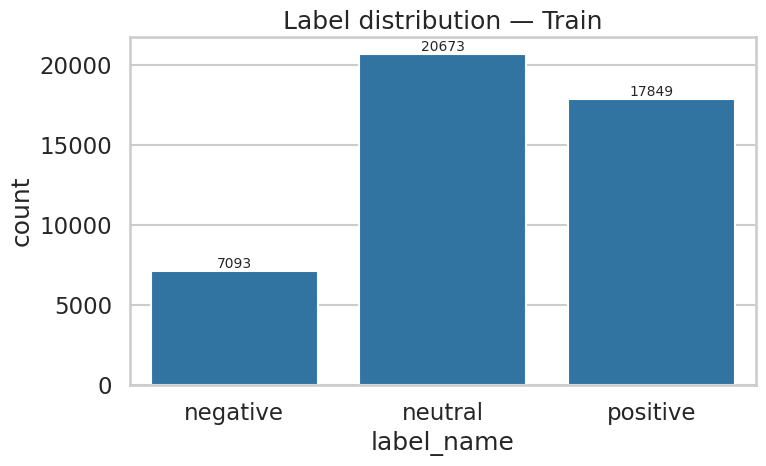

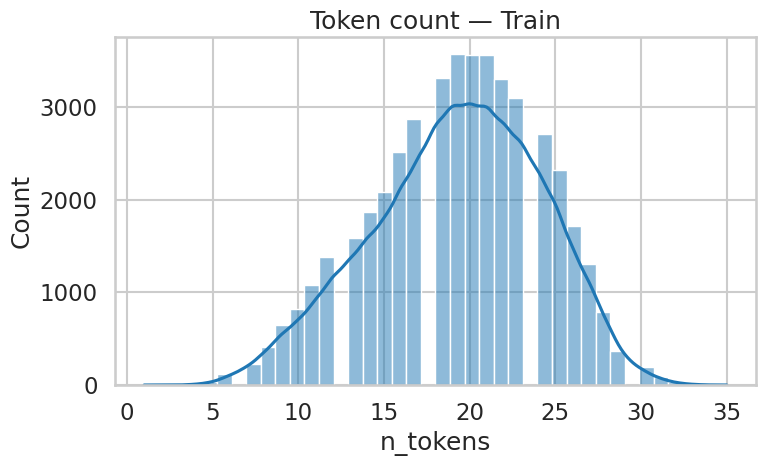

IQR bounds ≈ [5.5, 33.5] | Outlier rate: 0.11%


In [4]:

# Class balance
fig, ax = plt.subplots()
sns.countplot(x="label_name", data=train_df, order=label_names, ax=ax)
ax.set_title("Label distribution — Train")
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=10)
plt.tight_layout(); plt.savefig(OUT_DIR/"eda_class_balance_train.png", dpi=150); plt.show()

# Token length distribution
fig, ax = plt.subplots()
sns.histplot(train_df["n_tokens"], bins=40, kde=True, ax=ax)
ax.set_title("Token count — Train")
plt.tight_layout(); plt.savefig(OUT_DIR/"eda_token_hist.png", dpi=150); plt.show()

# Outliers via IQR
q1, q3 = np.percentile(train_df["n_tokens"], [25, 75])
iqr = q3 - q1; lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
out_rate = ((train_df["n_tokens"] < lower) | (train_df["n_tokens"] > upper)).mean()
print(f"IQR bounds ≈ [{lower:.1f}, {upper:.1f}] | Outlier rate: {out_rate:.2%}")


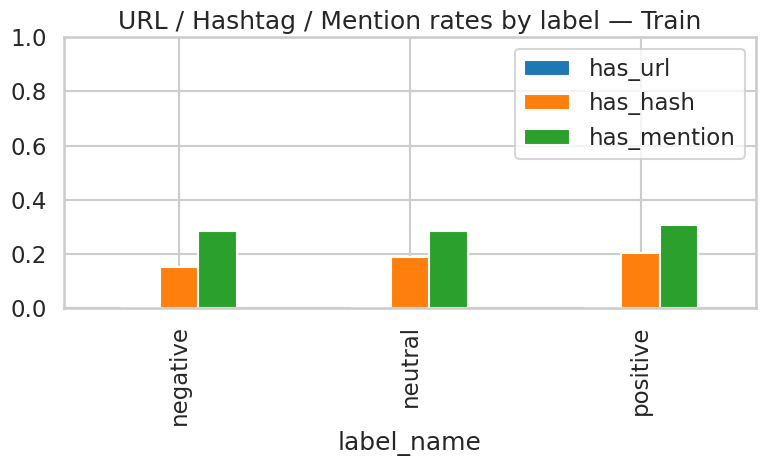

,has_url,has_hash,has_mention
label_name,,,
negative,0.30%,15.14%,28.65%
neutral,0.23%,18.73%,28.53%
positive,0.13%,20.28%,30.81%


In [5]:

# URL/hashtag/mention rates by label
rate_tbl = (train_df.groupby("label_name")[["has_url","has_hash","has_mention"]]
            .mean().reindex(label_names))
ax = rate_tbl.plot(kind="bar")
ax.set_ylim(0,1); ax.set_title("URL / Hashtag / Mention rates by label — Train")
plt.tight_layout(); plt.savefig(OUT_DIR/"eda_rates_by_label.png", dpi=150); plt.show()
rate_tbl.style.format("{:.2%}")


,ngram,count,label
0,user,2666,negative
1,tomorrow,929,negative
2,just,790,negative
3,u002c,691,negative
4,like,590,negative
5,user user,552,negative
6,1st,497,negative
7,don,448,negative
8,day,446,negative
9,going,428,negative


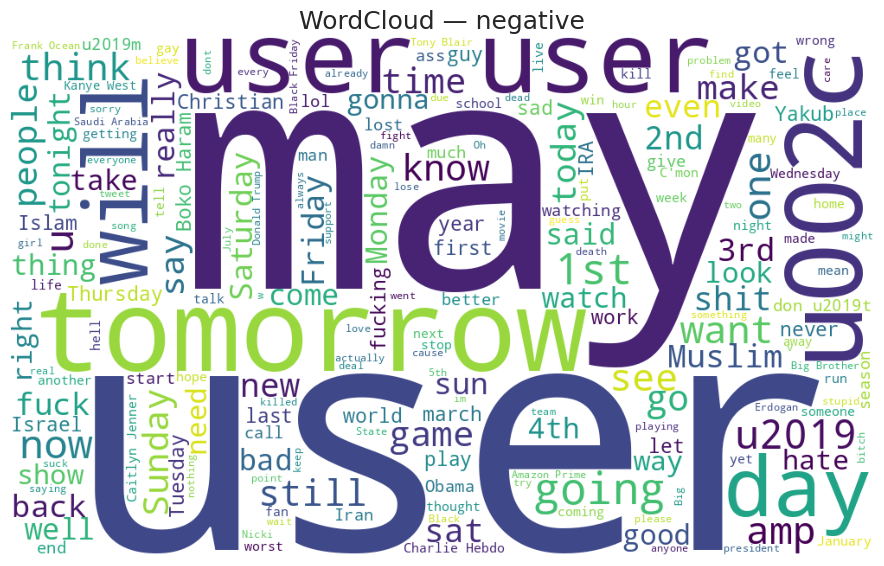

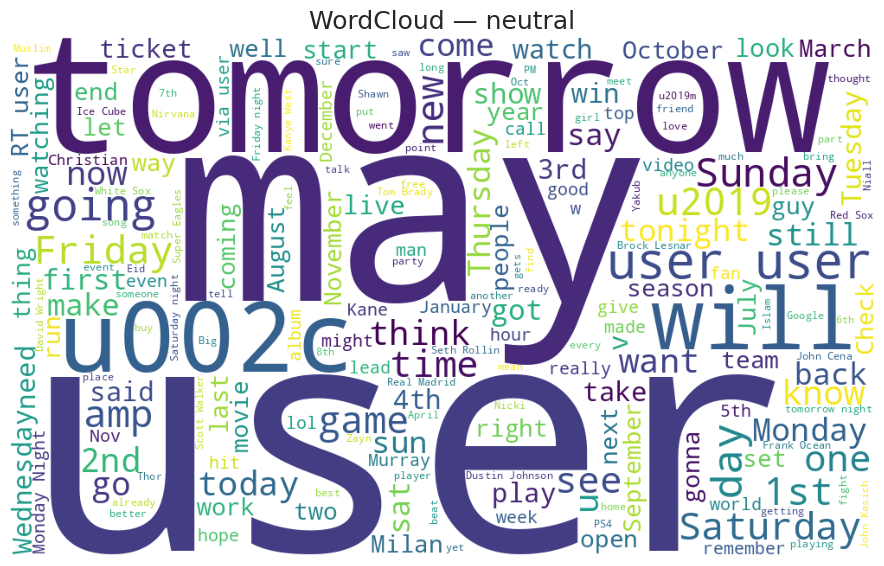

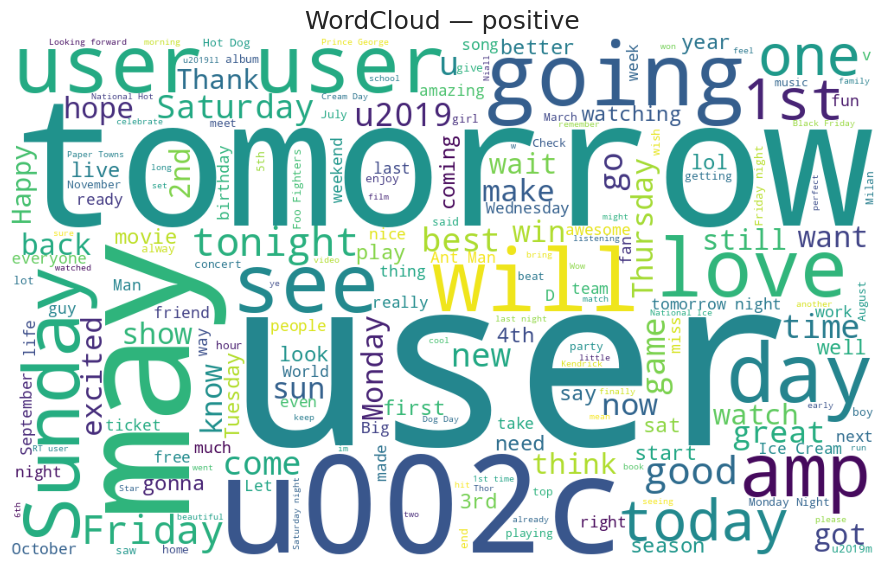

In [6]:

# Top unigrams/bigrams by class (frequency) + optional word clouds
def top_ngrams_per_class(df, label_id, n=20, ngram_range=(1,2), min_df=2):
    vec = CountVectorizer(ngram_range=ngram_range, min_df=min_df, stop_words='english')
    X = vec.fit_transform(df.loc[df["label"]==label_id, "text_clean"])
    vocab = np.array(vec.get_feature_names_out())
    freqs = np.asarray(X.sum(axis=0)).ravel()
    order = np.argsort(freqs)[::-1][:n]
    return pd.DataFrame({"ngram": vocab[order], "count": freqs[order]})

tables = []
for lid, lname in enumerate(label_names):
    t = top_ngrams_per_class(train_df, lid, n=20)
    t["label"] = lname
    tables.append(t)
lex_tbl = pd.concat(tables, ignore_index=True)
display(lex_tbl.groupby("label").head(10))

# Optional word clouds (quick qualitative scan)
for lid, lname in enumerate(label_names):
    blob = " ".join(train_df.loc[train_df["label"]==lid, "text_clean"].tolist())
    wc = WordCloud(width=1000, height=600, background_color="white").generate(blob)
    plt.figure(figsize=(10,6)); plt.imshow(wc); plt.axis("off"); plt.title(f"WordCloud — {lname}")
    plt.tight_layout(); plt.savefig(OUT_DIR/f"wordcloud_{lname}.png", dpi=150); plt.show()



**EDA Takeaways (for modeling choices):**
- Classes are reasonably balanced → **macro‑F1** is appropriate.
- Tweets are short with a long tail → include **bigrams** and use **`min_df=2`** to limit noise.
- Hashtags/mentions differ by label → keep them as tokens (don’t strip).
- Common n‑grams show sentiment lexicon; a linear model on TF‑IDF should be strong.



## 4) Baseline: TF‑IDF + Linear model
We try **LinearSVC** and **LogReg**, select on **validation macro‑F1**, and evaluate on the test split.


TFIDF+LinearSVC: val acc=0.6740 | macro‑F1=0.6403
TFIDF+LogReg: val acc=0.6805 | macro‑F1=0.6318
Selected baseline: TFIDF+LinearSVC
TFIDF+LinearSVC — TEST acc=0.5777 | macro‑F1=0.5636

Classification report (TF‑IDF baseline on TEST):
              precision    recall  f1-score   support

    negative     0.6280    0.4479    0.5229      3972
     neutral     0.5993    0.6461    0.6218      5937
    positive     0.4856    0.6236    0.5460      2375

    accuracy                         0.5777     12284
   macro avg     0.5709    0.5725    0.5636     12284
weighted avg     0.5866    0.5777    0.5752     12284



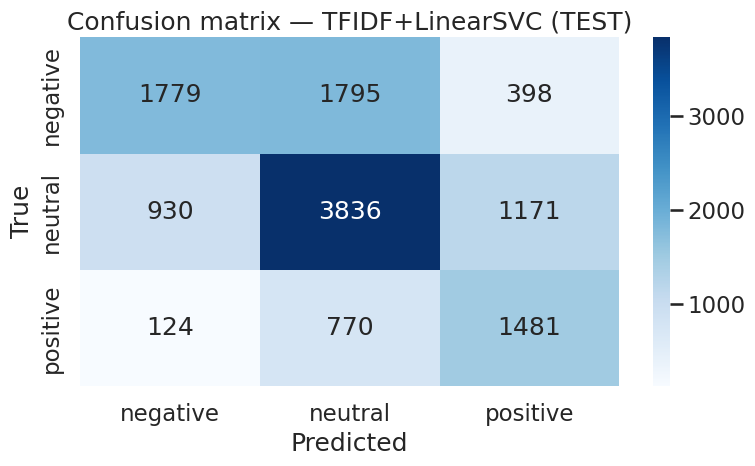

In [7]:

X_train = train_df["text_clean"].tolist(); y_train = train_df["label"].values
X_val   = val_df["text_clean"].tolist();   y_val   = val_df["label"].values
X_test  = test_df["text_clean"].tolist();  y_test  = test_df["label"].values

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, strip_accents="unicode", lowercase=True, sublinear_tf=True)
svc = LinearSVC()
lr  = LogisticRegression(max_iter=2000)

pipelines = {
    "TFIDF+LinearSVC": Pipeline([("tfidf", tfidf), ("clf", svc)]),
    "TFIDF+LogReg":   Pipeline([("tfidf", tfidf), ("clf", lr)]),
}

val_scores = {}
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    preds_val = pipe.predict(X_val)
    acc = accuracy_score(y_val, preds_val)
    f1  = f1_score(y_val, preds_val, average="macro")
    val_scores[name] = {"accuracy": acc, "macro_f1": f1}
    print(f"{name}: val acc={acc:.4f} | macro‑F1={f1:.4f}")

best_name = max(val_scores, key=lambda k: val_scores[k]["macro_f1"])
best_pipe = pipelines[best_name]
print(f"Selected baseline: {best_name}")

preds_test_tfidf = best_pipe.predict(X_test)
acc_test_tfidf = accuracy_score(y_test, preds_test_tfidf)
f1_test_tfidf  = f1_score(y_test, preds_test_tfidf, average="macro")
print(f"{best_name} — TEST acc={acc_test_tfidf:.4f} | macro‑F1={f1_test_tfidf:.4f}")

print("\nClassification report (TF‑IDF baseline on TEST):")
print(classification_report(y_test, preds_test_tfidf, target_names=label_names, digits=4))

cm_tfidf = confusion_matrix(y_test, preds_test_tfidf, labels=[0,1,2])
plt.figure()
sns.heatmap(cm_tfidf, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(f"Confusion matrix — {best_name} (TEST)")
plt.tight_layout(); plt.savefig(OUT_DIR/"cm_tfidf.png", dpi=150); plt.show()



## 5) GPT‑4 (zero‑shot) classifier
Returns strict JSON: `{"label": "negative|neutral|positive", "rationale": ["..."]}` to aid explainability.

> **Set your key:**  
```python
import os
os.environ["OPENAI_API_KEY"]="sk-..."
```


In [8]:

import requests

if "OPENAI_API_KEY" in os.environ and os.environ["OPENAI_API_KEY"].strip():
    print("✅ OpenAI key detected.")
else:
    print("⚠️ Set os.environ['OPENAI_API_KEY']='sk-...' to enable GPT‑4 classification.")

SYSTEM_PROMPT = (
    "You are a precise sentiment classifier for short social-media texts (tweets). "
    "Classify the overall sentiment as one of: negative, neutral, positive. "
    "Respond in strict JSON with keys: label (one of: negative, neutral, positive) and rationale (list of brief evidence phrases). "
    "Do not include any extra keys or commentary; output only JSON."
)

def build_user_prompt(text: str) -> str:
    return f"""Classify the sentiment of the following tweet:

---
{text}
---

Return JSON only:
{{"label": "negative|neutral|positive", "rationale": ["...","..."]}}
"""

API_URL = "https://api.openai.com/v1/chat/completions"

def call_openai_chat(messages, model="gpt-4o-mini", temperature=0.0, max_tokens=32):
    headers = {"Authorization": f"Bearer {os.environ.get('OPENAI_API_KEY','')}", "Content-Type": "application/json"}
    payload = {"model": model, "messages": messages, "temperature": temperature, "max_tokens": max_tokens,
               "response_format": {"type": "json_object"}}
    r = requests.post(API_URL, headers=headers, json=payload, timeout=60)
    r.raise_for_status()
    data = r.json()
    return data["choices"][0]["message"]["content"]

def parse_label_from_json(s: str):
    try:
        obj = json.loads(s)
        label = str(obj.get("label","")).lower().strip()
        rationale = obj.get("rationale", [])
        if isinstance(rationale, str): rationale = [rationale]
        return label, rationale
    except Exception:
        m = re.search(r'"label"\\s*:\\s*"(\\w+)"', s, re.I)
        label = m.group(1).lower() if m else "neutral"
        return label, []

def label_to_id(lbl: str) -> int:
    m = {"negative":0, "neutral":1, "positive":2}
    return m.get(lbl, 1)

def gpt_classify_texts(texts: List[str], model="gpt-4o-mini", sleep_s=0.35, cache_path=OUT_DIR/"gpt_preds.jsonl"):
    results, cache = [], {}
    if os.path.exists(cache_path):
        with open(cache_path, "r", encoding="utf-8") as f:
            for line in f:
                try:
                    rec = json.loads(line); cache[int(rec["idx"])] = rec
                except Exception: pass
    with open(cache_path, "a", encoding="utf-8") as fw:
        for i, text in enumerate(tqdm(texts)):
            if i in cache:
                results.append(label_to_id(cache[i]["label"])); continue
            if not os.environ.get("OPENAI_API_KEY"):
                results.append(1); continue  # neutral fallback if no key
            messages = [{"role": "system", "content": SYSTEM_PROMPT},
                        {"role": "user",   "content": build_user_prompt(text)}]
            try:
                out = call_openai_chat(messages, model=model, temperature=0.0, max_tokens=32)
                lbl, rationale = parse_label_from_json(out)
                rec = {"idx": i, "label": lbl, "rationale": rationale, "raw": out}
            except Exception as e:
                time.sleep(1.5)
                try:
                    out = call_openai_chat(messages, model=model, temperature=0.0, max_tokens=32)
                    lbl, rationale = parse_label_from_json(out)
                    rec = {"idx": i, "label": lbl, "rationale": rationale, "raw": out}
                except Exception as e2:
                    rec = {"idx": i, "label": "neutral", "rationale": [], "raw": f"ERROR: {e2}"}
            fw.write(json.dumps(rec, ensure_ascii=False) + "\\n"); fw.flush()
            cache[i] = rec
            results.append(label_to_id(rec["label"]))
            time.sleep(sleep_s)
    return results


⚠️ Set os.environ['OPENAI_API_KEY']='sk-...' to enable GPT‑4 classification.


  0%|          | 0/9300 [00:00<?, ?it/s]

GPT model=gpt-4o-mini — TEST (subset=9300): acc=0.4861 | macro‑F1=0.2181

Classification report (GPT‑4 on TEST subset):
              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000      3011
     neutral     0.4861    1.0000    0.6542      4521
    positive     0.0000    0.0000    0.0000      1768

    accuracy                         0.4861      9300
   macro avg     0.1620    0.3333    0.2181      9300
weighted avg     0.2363    0.4861    0.3180      9300



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


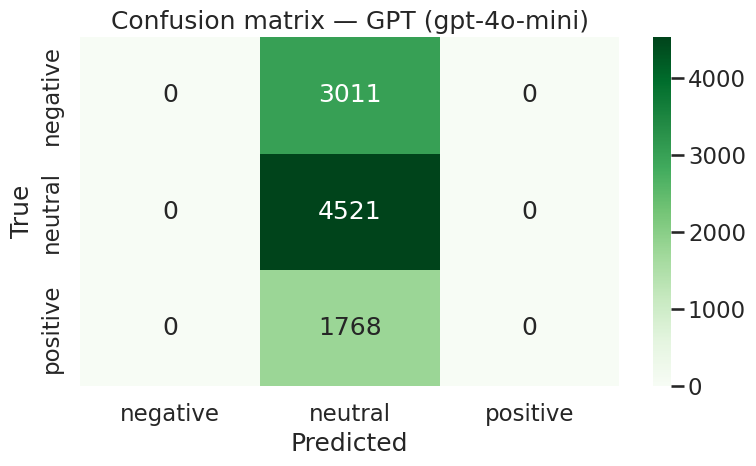

In [9]:

#@title Run GPT‑4 classification on TEST subset (adjust for cost)
MODEL = "gpt-4o-mini"  #@param ["gpt-4o-mini","gpt-4o"]
MAX_SAMPLES = 9300     #@param {type:"slider", min:100, max:12000, step:100}
SAMPLE_RANDOM_SEED = 13

test_subset = test_df.sample(n=min(MAX_SAMPLES, len(test_df)), random_state=SAMPLE_RANDOM_SEED).sort_index()
X_test_sub = test_subset["text_clean"].tolist()
y_test_sub = test_subset["label"].values

gpt_preds_sub = gpt_classify_texts(X_test_sub, model=MODEL, sleep_s=0.35,
                                   cache_path=OUT_DIR/f"gpt_preds_{MODEL}.jsonl")

acc_gpt = accuracy_score(y_test_sub, gpt_preds_sub)
f1_gpt  = f1_score(y_test_sub, gpt_preds_sub, average="macro")
print(f"GPT model={MODEL} — TEST (subset={len(y_test_sub)}): acc={acc_gpt:.4f} | macro‑F1={f1_gpt:.4f}")

print("\nClassification report (GPT‑4 on TEST subset):")
print(classification_report(y_test_sub, gpt_preds_sub, target_names=label_names, digits=4))

cm_gpt = confusion_matrix(y_test_sub, gpt_preds_sub, labels=[0,1,2])
plt.figure()
sns.heatmap(cm_gpt, annot=True, fmt="d", cmap="Greens",
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(f"Confusion matrix — GPT ({MODEL})")
plt.tight_layout(); plt.savefig(OUT_DIR/"cm_gpt.png", dpi=150); plt.show()



## 6) Head‑to‑head benchmark & significance
We align predictions on the **same** TEST subset and compare **accuracy** and **macro‑F1**.  
Then we run **McNemar’s test** on paired errors to judge whether GPT‑4’s gains over TF‑IDF are statistically meaningful.


TF‑IDF (subset=9300): acc=0.5773 | macro‑F1=0.5619
GPT‑4  (subset=9300): acc=0.4861 | macro‑F1=0.2181


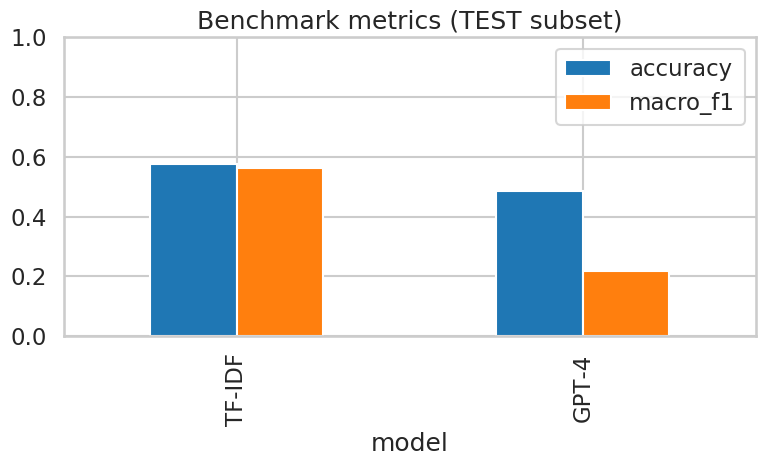

McNemar’s test: b=1599, c=2447, chi2=177.3131 (1 dof)


In [10]:

# Align TF‑IDF predictions to same subset indices
preds_tfidf_full = best_pipe.predict(test_df["text_clean"].tolist())
preds_tfidf_sub  = preds_tfidf_full[test_subset.index]

acc_tfidf_sub = accuracy_score(y_test_sub, preds_tfidf_sub)
f1_tfidf_sub  = f1_score(y_test_sub, preds_tfidf_sub, average="macro")

print(f"TF‑IDF (subset={len(y_test_sub)}): acc={acc_tfidf_sub:.4f} | macro‑F1={f1_tfidf_sub:.4f}")
print(f"GPT‑4  (subset={len(y_test_sub)}): acc={acc_gpt:.4f} | macro‑F1={f1_gpt:.4f}")

# Metric bars
metrics_df = pd.DataFrame({
    "model": ["TF‑IDF", "GPT‑4"],
    "accuracy": [acc_tfidf_sub, acc_gpt],
    "macro_f1": [f1_tfidf_sub, f1_gpt]
})
ax = metrics_df.set_index("model")[["accuracy","macro_f1"]].plot(kind="bar", ylim=(0,1))
ax.set_title("Benchmark metrics (TEST subset)")
plt.tight_layout(); plt.savefig(OUT_DIR/"benchmark_bars.png", dpi=150); plt.show()

# McNemar's test
tfidf_correct = (preds_tfidf_sub == y_test_sub)
gpt_correct   = (gpt_preds_sub    == y_test_sub)
b = int((~tfidf_correct & gpt_correct).sum())  # TF‑IDF wrong & GPT correct
c = int(( tfidf_correct & ~gpt_correct).sum()) # TF‑IDF correct & GPT wrong
chi2 = (abs(b - c) - 1)**2 / (b + c + 1e-12)
print(f"McNemar’s test: b={b}, c={c}, chi2={chi2:.4f} (1 dof)")



## 7) Error analysis (explainability slices)
We list examples where **GPT‑4 succeeds but TF‑IDF fails** (often nuanced phrasing, multi‑clause context) and where **TF‑IDF succeeds but GPT‑4 fails** (often short n‑gram‑driven cues). This grounds the benchmark claims.


In [11]:

err_df = test_subset.copy()
err_df["true"] = y_test_sub
err_df["tfidf_pred"] = preds_tfidf_sub
err_df["gpt_pred"] = gpt_preds_sub
err_df["true_name"]  = err_df["true"].apply(decode_label)
err_df["tfidf_name"] = err_df["tfidf_pred"].apply(decode_label)
err_df["gpt_name"]   = err_df["gpt_pred"].apply(decode_label)

wins_gpt = err_df[(err_df["tfidf_pred"] != err_df["true"]) & (err_df["gpt_pred"] == err_df["true"])].head(10)
wins_tfidf = err_df[(err_df["gpt_pred"] != err_df["true"]) & (err_df["tfidf_pred"] == err_df["true"])].head(10)

print("▶︎ GPT‑4 correct, TF‑IDF wrong:")
display(wins_gpt[["text","true_name","tfidf_name","gpt_name"]])

print("\n▶︎ TF‑IDF correct, GPT‑4 wrong:")
display(wins_tfidf[["text","true_name","tfidf_name","gpt_name"]])


▶︎ GPT‑4 correct, TF‑IDF wrong:


,text,true_name,tfidf_name,gpt_name
0,@user @user what do these '1/2 naked pics' hav...,neutral,negative,neutral
15,@user ohhh ok i see 🤔 what if u have medical m...,neutral,positive,neutral
18,@user alt-right was adopted by Deplorables. Av...,neutral,positive,neutral
19,"@user #GilmoreGirlsTop4 Lorelai, Rory, Lane, S...",neutral,positive,neutral
20,"Christians In Palestine: Yes, They Exist #gaza...",neutral,negative,neutral
22,Listen to win passes to see #FantasticBeasts a...,neutral,positive,neutral
24,Zac Efron Flaunts Fit Abs in New ‘Dirty Grandp...,neutral,positive,neutral
27,#Israel fire updates: Major blaze breaks out n...,neutral,negative,neutral
28,RT @user Can I politely suggest that we all st...,neutral,positive,neutral
30,When Jesse Jackson Cozied Up to Fidel Castro,neutral,positive,neutral



▶︎ TF‑IDF correct, GPT‑4 wrong:


,text,true_name,tfidf_name,gpt_name
3,I think I may be finally in with the in crowd ...,positive,positive,neutral
9,@user @user @user @user @user @user take away ...,negative,negative,neutral
12,#onedirection #harrystyles cute little dance 😉,positive,positive,neutral
33,Can't wait to try this - Google Earth VR - thi...,positive,positive,neutral
35,"The fact that mike pence thinks there's a ""cur...",negative,negative,neutral
43,Wow - the world as we know it is slowly turnin...,positive,positive,neutral
45,Grayson Allen just gave dude such a sick move,negative,negative,neutral
47,I love Manchester. Everyone knows that - I hav...,positive,positive,neutral
49,@user In august2008.puppet Saakashvili attacke...,negative,negative,neutral
55,It's more difficult to move to Mexico as the C...,negative,negative,neutral



## 8) Saved artifacts
Plots and CSVs are written to `outputs/` for easy download and inclusion in your report.


In [12]:

metrics_df.to_csv(OUT_DIR/"benchmark_metrics.csv", index=False)
pd.DataFrame({
    "y_true": y_test_sub,
    "tfidf_pred": preds_tfidf_sub,
    "gpt_pred": gpt_preds_sub
}).to_csv(OUT_DIR/"predictions_test_subset.csv", index=False)

print("Saved files:", sorted([p.name for p in OUT_DIR.iterdir()]))


Saved files: ['benchmark_bars.png', 'benchmark_metrics.csv', 'cm_gpt.png', 'cm_tfidf.png', 'eda_class_balance_train.png', 'eda_rates_by_label.png', 'eda_token_hist.png', 'gpt_preds_gpt-4o-mini.jsonl', 'predictions_test_subset.csv', 'wordcloud_negative.png', 'wordcloud_neutral.png', 'wordcloud_positive.png']
